## Paraphrases Template

In [76]:
# from google.colab import drive
# drive.mount('/content/drive')

In [77]:
import os

import pandas as pd
import numpy as np

import string
from nltk import download
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.metrics import jaccard_distance

from scipy.stats import pearsonr

import seaborn as sns
import matplotlib.pyplot as plt

download('stopwords')
download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\alber\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [78]:
dt = pd.read_csv('test-gold/STS.input.SMTeuroparl.txt',sep='\t',header=None)

In [79]:
dt.head()

,0,1
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi..."


In [80]:
dt['gs'] = pd.read_csv('test-gold/STS.gs.SMTeuroparl.txt',sep='\t',header=None)

In [81]:
dt.shape

(459, 3)

In [82]:
dt.head()

,0,1,gs
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,4.50
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,5.00
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,4.25
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,4.50
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...",5.00


## TODO
1. Compute the Jaccard similarity between every paraphrase and add a column *jaccard* to *dt* variable.
2. Compute the pearson correlation as: <br>
```
from scipy.stats import pearsonr
pearsonr(dt['gs'], dt['jaccard'])[0]
```

# Solution

## 1. Define Main Functions

Functions:

- **preprocess_reviews**: Preprocess the text and remove punctuations, convert to lowercase, remove stopwords
- **jaccard_sim**: Get the jaccard similarity between two strings
- **get_similarity**: Get the similarity between two strings
- **corr_with_gold**: Compute the pearson correlation between the gold standard and the similarity scores

In [83]:
# Creating a translation table to remove punctuation
translator = str.maketrans('', '', string.punctuation)
txt1 = "Hola que tal."
txt1.translate(translator)

'Hola que tal'

In [106]:
def preprocess_reviews(text, sw_lang='english', out_set=False):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''

    # Creating a translation table to remove punctuation
    translator = str.maketrans('', '', string.punctuation)

    # Processing the text, removing punctuation and converting to lowercase
    processed_text = text.translate(translator).lower().strip()

    # Tokenize the text
    ls_processed_text = word_tokenize(processed_text)

    # Removing stopwords
    ls_processed_text = [word for word in ls_processed_text if word not in stopwords.words(sw_lang)]

    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text

def jaccard_sim(x, y):
    '''
    Get the Jaccard similarity between two sets
    '''
    return 1 - jaccard_distance(x, y)

def get_similarity(x, y, similarity=jaccard_sim):
    '''
    Get the similarity between two strings
    '''

    # Clean the sentences and return a set of words
    x_prep = preprocess_reviews(x, out_set=True)
    y_prep = preprocess_reviews(y, out_set=True)

    # Return the similarity between the two sets of words
    return similarity(x_prep, y_prep)
    
def corr_with_gold(filename, similarity=jaccard_sim):
    '''
    Returns the correlation between the gold standard and the similarity
    Input: filename - string with the name of the file
    Output: Pearson correlation object
    '''

    # In some of the files, tabulations appear as \t instead of a tab
    # To solve this problem, it's been included \\t (escaped "\") as a possible separator
    dt = pd.read_csv('test-gold/STS.input.' + filename,sep='\t|\\t',
                     header=None, on_bad_lines='skip', engine='python')
    dt['gs'] = pd.read_csv('test-gold/STS.gs.'+filename,sep='\t|\\t',header=None, 
                           on_bad_lines='skip', engine='python')
    
    # Bad lines are inserted as null values sometimes 
    # They are counted, informed and removed
    nulls = dt[dt.isnull().any(axis=1)]
    if len(nulls) > 0:
        print(filename, '\n', nulls)
        dt = dt.dropna()

    # Get the similarity between the two sentences
    arr_sim = dt.apply(lambda x: get_similarity(*x[:2], similarity=similarity) , axis=1).values
    
    return pearsonr(arr_sim, dt['gs'].values)

def ind_report(filename):
    print("=====================================================")
    print(filename)
    print("=====================================================")
    print("\n")
    df_ind_report = pd.read_csv(f'test-gold/STS.input.{filename}.txt',sep='\t|\\t',header=None, engine='python')
    df_ind_report['gs'] = pd.read_csv(f'test-gold/STS.gs.{filename}.txt',sep='\t|\\t',header=None, engine='python')
    df_ind_report['sim'] = df_ind_report.apply(lambda x: get_similarity(*x[:2]) , axis=1)
    df_ind_report['sim'] *= 5.
    df_ind_report['dif'] = df_ind_report['sim'] - df_ind_report['gs']

    difs_tail = df_ind_report.sort_values(by='dif', ascending=False).tail(5)
    for idx, row in difs_tail.iterrows():
        x, y = row[0], row[1]
        prep_x, prep_y = preprocess_reviews(x, out_set=True), preprocess_reviews(y, out_set=True)
        print(f"RAW TEXT (DIFFERENCE {row['dif']:.2f})")
        print(x, '\n', y)
        print("\nPREPROCESSED TEXT")
        print(prep_x, '\n', prep_y)
        print("INTERSECTION", prep_x.intersection(prep_y))
        print("DIFFERENCE", prep_x.difference(prep_y).union(prep_y.difference(prep_x)))
        print('\n\n')

    fig, ax = plt.subplots(1, 2, figsize=(10,2.5))
    plt.suptitle(filename)
    df_ind_report.dif.plot.hist(bins=20, title="Residuals", ax=ax[0])
    df_ind_report.dif.plot.box(title="Residuals", ax=ax[1]);

    return df_ind_report

## 2. Compute Jaccard Similarity

The **Jaccard similarity** measures the similarity between two sets of data to see which members are shared and distinct. The Jaccard similarity is calculated by dividing the number of observations in both sets by the number of observations in either set. In other words, the Jaccard similarity can be computed as the size of the intersection divided by the size of the union of two sets. This can be written in set notation using intersection and unions of two sets:

$$
J(A, B) = \frac {|A \cap B|}{|A \cup B|}
$$

Given its nature, it must be between 0 and 1, where 0 means no similarity and 1 means the two sets are identical.

As our given gold standard is in a different range, we will use the **Pearson correlation** to measure the correlation between the gold standard and the similarity scores.

### 2.1 Calculations for the example (``MSRpar``)

MSR-Paraphrase, Microsoft Research Paraphrase Corpus
http://research.microsoft.com/en-us/downloads/607d14d9-20cd-47e3-85bc-a2f65cd28042/
750 pairs of sentences.

In [85]:
# Get the array of similarities between each pair of sentences
arr_sim = dt.apply(lambda x: get_similarity(*x[:2]) , axis=1).values
print("First 5 Jaccard similarities (between 0 and 1):\n ", arr_sim[:5], '\n')

print("First 5 gold standard values (between 0 and 5):\n ", dt['gs'].values[:5], '\n')

d_to_gold = pearsonr(arr_sim, dt['gs'].values)
print("Pearson correlation between the gold standard and the similarity:\n", d_to_gold.statistic, '\n')
print("95% confidence interval:\n", f"({d_to_gold.confidence_interval(.95).low}, {d_to_gold.confidence_interval(.95).high})")


First 5 Jaccard similarities (between 0 and 1):
  [0.28571429 0.75       0.27272727 0.42857143 1.        ] 

First 5 gold standard values (between 0 and 5):
  [4.5  5.   4.25 4.5  5.  ] 

Pearson correlation between the gold standard and the similarity:
 0.4688903043162896 

95% confidence interval:
 (0.3942845908221308, 0.5373559593014341)


### 2.2 Calculations for the rest of the datasets

From `00-readme.txt`:

```
The dataset comprises pairs of sentences drawn from the publicly
available datasets used in training:

- MSR-Paraphrase, Microsoft Research Paraphrase Corpus
  http://research.microsoft.com/en-us/downloads/607d14d9-20cd-47e3-85bc-a2f65cd28042/
  750 pairs of sentences.

- MSR-Video, Microsoft Research Video Description Corpus
  http://research.microsoft.com/en-us/downloads/38cf15fd-b8df-477e-a4e4-a4680caa75af/
  750 pairs of sentences.

- SMTeuroparl: WMT2008 development dataset (Europarl section)
  http://www.statmt.org/wmt08/shared-evaluation-task.html
  459 pairs of sentences.

In addition, it contains two surprise datasets comprising the
following collections:

- SMTnews: news conversation sentence pairs from WMT
  399 pairs of sentences.

- OnWN: pairs of sentences where the first comes from Ontonotes and
  the second from a WordNet definition.
  750 pairs of sentences.
```

In [86]:
print("List of Files\n")

for filename in os.listdir('test-gold'):
    print(filename)


List of Files

00-readme.txt
STS.gs.ALL.txt
STS.gs.MSRpar.txt
STS.gs.MSRvid.txt
STS.gs.SMTeuroparl.txt
STS.gs.surprise.OnWN.txt
STS.gs.surprise.SMTnews.txt
STS.input.MSRpar.txt
STS.input.MSRvid.txt
STS.input.SMTeuroparl.txt
STS.input.surprise.OnWN.txt
STS.input.surprise.SMTnews.txt


The files containing `gs` refer to the gold standard, and the files containing `input` refer to the paraphrases.

In [87]:
ls_files = ["MSRpar.txt", "MSRvid.txt", "SMTeuroparl.txt", "surprise.OnWN.txt", "surprise.SMTnews.txt"]

# Initialize the scores dataframe
df_scores = pd.DataFrame(columns=['file','pearson','p_value', 'conf_low', 'conf_high'])
ls_corr = []
ls_p_value = []
ls_conf_low, ls_conf_high = [], []

# Repeat the process applied to the first file for all the rest
# Save the results in a dataframe
for file in ls_files:
    print(f"Processing {file}")
    pearson_stats = corr_with_gold(file)
    ls_corr.append(pearson_stats.statistic)
    ls_p_value.append(pearson_stats.pvalue)
    ls_conf_low.append(pearson_stats.confidence_interval(.95).low)
    ls_conf_high.append(pearson_stats.confidence_interval(.95).high)

df_scores['file'] = ls_files
df_scores['pearson'] = ls_corr
df_scores['p_value'] = ls_p_value
df_scores['conf_low'] = ls_conf_low
df_scores['conf_high'] = ls_conf_high

df_scores

Processing MSRpar.txt
Processing MSRvid.txt
Processing SMTeuroparl.txt
Processing surprise.OnWN.txt
Processing surprise.SMTnews.txt


,file,pearson,p_value,conf_low,conf_high
0,MSRpar.txt,0.537935,1.764245e-57,0.485024,0.586921
1,MSRvid.txt,0.685804,2.552113e-105,0.645928,0.721948
2,SMTeuroparl.txt,0.468890,1.815700e-26,0.394285,0.537356
3,surprise.OnWN.txt,0.630726,1.918617e-84,0.585578,0.671973
4,surprise.SMTnews.txt,0.391114,4.920681e-16,0.304637,0.471196


The previous results can be more easily analyzed in the following plot:

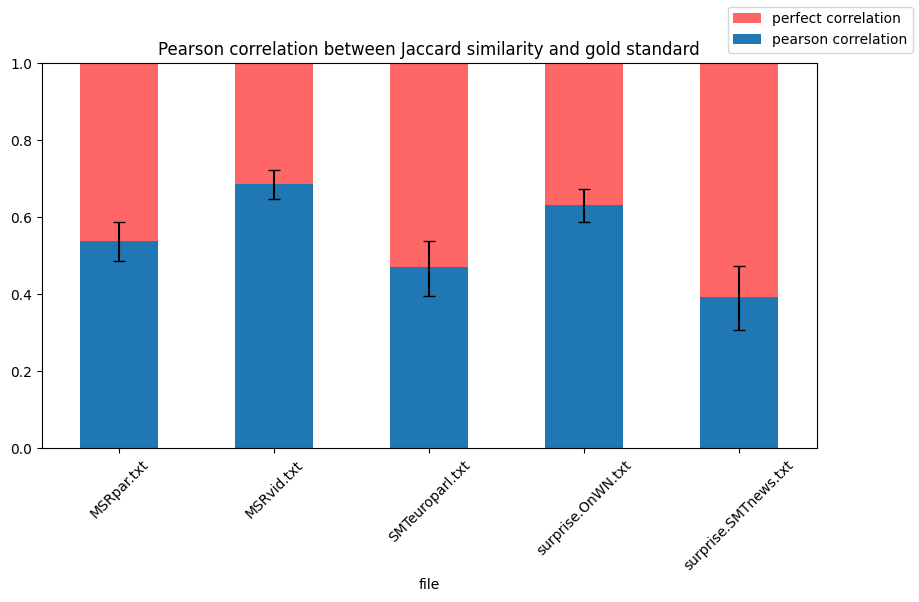

In [88]:
err_bars = np.abs(df_scores['pearson'].T.values - df_scores[['conf_low', 'conf_high']].T.values)

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.bar(df_scores.file, [1.]*len(df_scores), color='red', alpha=.6, label='perfect correlation', width=0.5)
df_scores.plot.bar(x='file', y='pearson', rot=45, ax=ax, yerr=err_bars, capsize=4, 
                   title='Pearson correlation between Jaccard similarity and gold standard', legend=False)
ax.set_ylim([0.,1.])
fig.legend(['perfect correlation', 'pearson correlation']);

## 3. Other similarity metrics

Dice, Jaccard, Overlap, and Cosine are all similarity measurements used in the context of set or vector comparisons, particularly in text analysis and information retrieval. Here are the differences between these four similarity measurements:

1. **Dice Similarity (Sørensen-Dice coefficient):**
   - Dice similarity is used to measure the similarity between two sets or binary data.
   - It is calculated as twice the size of the intersection of the sets divided by the sum of the sizes of the sets.
   - Values range from 0 (no similarity) to 1 (perfect similarity).
   - Commonly applied in text mining and document retrieval.

2. **Jaccard Similarity:**
   - Jaccard similarity is also used for comparing sets or binary data.
   - It calculates the size of the intersection of two sets divided by the size of the union of the sets.
   - Values range from 0 (no similarity) to 1 (perfect similarity).
   - Widely used in information retrieval, clustering, and recommendation systems.

3. **Overlap Coefficient:**
   - The overlap coefficient is similar to Jaccard similarity but emphasizes the size of the intersection relative to the smaller of the two sets.
   - Values also range from 0 (no similarity) to 1 (perfect similarity).
   - Often used in biology for measuring the similarity of DNA sequences and in other set-based comparisons.

4. **Cosine Similarity:**
   - Cosine similarity measures the cosine of the angle between two vectors in a multi-dimensional space.
   - It is frequently used in natural language processing, document analysis, and recommendation systems to compare the similarity of vector representations of text data.
   - Values range from -1 (perfectly dissimilar, opposite directions) to 1 (perfectly similar, same direction), with 0 indicating orthogonality (no similarity).

The choice between these similarity measurements depends on the specific characteristics of your data and the context of your analysis. Cosine similarity is commonly used for comparing text documents when represented as vectors (e.g., TF-IDF or word embeddings), while Dice, Jaccard, and Overlap are more suitable for set-based data or binary data. Each of them has its strengths and weaknesses, and the choice should be based on the problem at hand.

$$S_{dice}(X,Y)=\frac{2\cdot \vert X \cap Y\vert}{\vert X\vert+\vert Y\vert}$$

$$S_{jaccard}(X,Y)=\frac{\vert X \cap Y\vert}{\vert X \cup Y\vert}$$

$$S_{overlap}(X,Y)=\frac{\vert X \cap Y\vert}{min(\vert X\vert,\vert Y\vert)}$$

$$S_{cosine}(X,Y)=\frac{\vert X \cap Y\vert}{\sqrt{\vert X\vert\cdot\vert Y\vert}}$$

In [89]:
# For sake of simplicity, the metrics are defined as functions
def dice_sim(x, y):
    x_n_y = x.intersection(y)
    return 2*len(x_n_y) / (len(x) + len(y))

def overlap_sim(x, y):
    x_n_y = x.intersection(y)
    return len(x_n_y) / min(len(x), len(y))

def cosine_sim(x, y):
    x_n_y = x.intersection(y)
    return len(x_n_y) / np.sqrt(len(x)*len(y))

In [90]:
# The different similarity metrics are calculated with their corresponding pearson correlation

d_similarities = {"jaccard": jaccard_sim, "dice": dice_sim, "overlap": overlap_sim, "cosine": cosine_sim}
ls_files = ["MSRpar.txt", "MSRvid.txt", "SMTeuroparl.txt", "surprise.OnWN.txt", "surprise.SMTnews.txt"]
ls_cols = ['file', 'similarity', 'pearson','p_value', 'conf_low', 'conf_high'] 

# Initialize the scores dataframe
df_scores = pd.DataFrame(columns=ls_cols)

for sim_name, sim_func in d_similarities.items():
    print("=" * 50)
    print(f"Similarity: {sim_name}")
    print("=" * 50)
    print("\n")
    
    df_scores_i = pd.DataFrame(columns=ls_cols)

    ls_corr = []
    ls_p_value = []
    ls_conf_low, ls_conf_high = [], []

    # Repeat the process applied to the first file for all the rest
    # Save the results in a dataframe
    for file in ls_files:
        print(f"Processing {file}")
        pearson_stats = corr_with_gold(file, similarity=sim_func)
        ls_corr.append(pearson_stats.statistic)
        ls_p_value.append(pearson_stats.pvalue)
        ls_conf_low.append(pearson_stats.confidence_interval(.95).low)
        ls_conf_high.append(pearson_stats.confidence_interval(.95).high)

    df_scores_i['file'] = ls_files
    df_scores_i['similarity'] = sim_name
    df_scores_i['pearson'] = ls_corr
    df_scores_i['p_value'] = ls_p_value
    df_scores_i['conf_low'] = ls_conf_low
    df_scores_i['conf_high'] = ls_conf_high

    df_scores = pd.concat([df_scores, df_scores_i], axis=0, ignore_index=True)

Similarity: jaccard


Processing MSRpar.txt
Processing MSRvid.txt
Processing SMTeuroparl.txt
Processing surprise.OnWN.txt
Processing surprise.SMTnews.txt
Similarity: dice


Processing MSRpar.txt
Processing MSRvid.txt
Processing SMTeuroparl.txt
Processing surprise.OnWN.txt
Processing surprise.SMTnews.txt
Similarity: overlap


Processing MSRpar.txt
Processing MSRvid.txt
Processing SMTeuroparl.txt
Processing surprise.OnWN.txt
Processing surprise.SMTnews.txt
Similarity: cosine


Processing MSRpar.txt
Processing MSRvid.txt
Processing SMTeuroparl.txt
Processing surprise.OnWN.txt
Processing surprise.SMTnews.txt


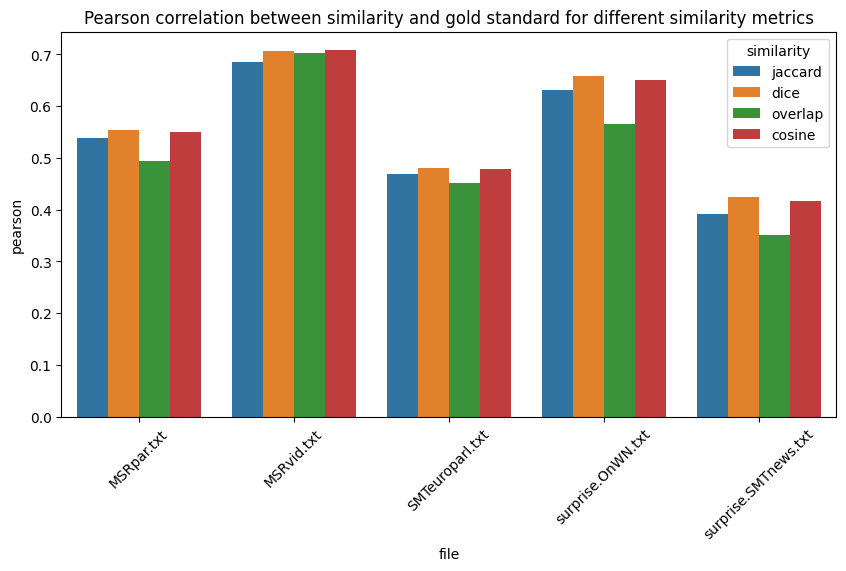

In [91]:
plt.figure(figsize=(10,5))
sns.barplot(x='file', y='pearson', hue='similarity', data=df_scores)
plt.title('Pearson correlation between similarity and gold standard for different similarity metrics')
plt.xticks(rotation=45);

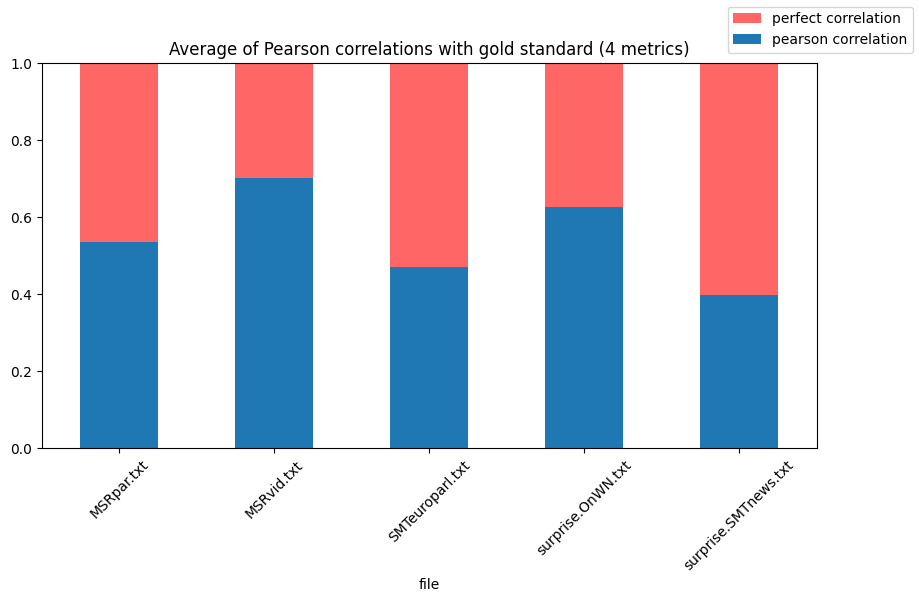

In [92]:
df_scores_avg = df_scores.groupby(['file']).pearson.mean().reset_index()

fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.bar(df_scores_avg.file, [1.]*len(df_scores_avg), color='red', alpha=.6, label='perfect correlation', width=0.5)
df_scores_avg.plot.bar(x='file', y='pearson', rot=45, ax=ax,
                   title='Average of Pearson correlations with gold standard (4 metrics)', legend=False)
ax.set_ylim([0.,1.])
fig.legend(['perfect correlation', 'pearson correlation']);

## 4. Result Analysis

As it's been shown from previous results, the correlation with gold standard is not strongly dependent on the metric used. There are some differences but they are all in the same range.

However, important differences can be seen in the correlation between the different datasets. The best results are obtained for the `MSRVid` and `OnWN` datasets, and the worst for the `MSRpar`, `SMTeuroparl`and `SMTNews` dataset. This is probably related to the amount of paraphrases in each dataset.

In order to get a better understanding of the results, the difference between the gold standard and the similarity scores (rescaled to be between 0 and 5) is checked for each dataset.

### 4.1. Worst Performing Datasets

#### 4.1.1. MSRpar

MSRpar is a dataset created by Microsoft Research (MSR) for evaluating text similarity algorithms. It consists of 5801 pairs of sentences collected from various news sources on the web over an 18-month period. Approximately 67% of these pairs are labeled as paraphrases, indicating that they convey similar meanings but not necessarily identical ones. The inter-annotator agreement for this dataset falls between 82% and 84%.

MSRpar includes a range of sentence pairs that vary in their degree of semantic similarity. Some pairs are completely unrelated, some partially overlap in meaning, and others are almost but not quite semantically equivalent. This diversity in annotations enriches the dataset with nuanced similarity labels.

**Statistic Results**

- Displaced distribution (1 out of 5). It can be understood as a miscalibration of the method. 
- In this case the main reason seems to be the difference between verb tenses, gender, etc as a result of the paraphrasing.
- It can be improved with more sofisticated techniques such as lemmatization or stemming.

MSRpar


RAW TEXT (DIFFERENCE -3.33)
The company claims it's the largest single Apple VAR Xserve sale to date. 
 The company claimed it is the largest sale of Xserves by an Apple retailer.

PREPROCESSED TEXT
{'claims', 'single', 'xserve', 'company', 'var', 'largest', 'date', 'apple', 'sale'} 
 {'retailer', 'company', 'largest', 'claimed', 'xserves', 'apple', 'sale'}
INTERSECTION {'apple', 'largest', 'company', 'sale'}
DIFFERENCE {'var', 'date', 'claims', 'single', 'claimed', 'retailer', 'xserves', 'xserve'}



RAW TEXT (DIFFERENCE -3.40)
The problem likely will mean corrective changes before the shuttle fleet starts flying again. 
 He said the problem needs to be corrected before the space shuttle fleet is cleared to fly again.

PREPROCESSED TEXT
{'changes', 'corrective', 'likely', 'fleet', 'starts', 'problem', 'shuttle', 'flying', 'mean'} 
 {'fly', 'needs', 'said', 'corrected', 'fleet', 'problem', 'shuttle', 'cleared', 'space'}
INTERSECTION {'problem', 'shuttle', 'fleet'}
DIFFERENCE {

,0,1,gs,sim,dif
0,The problem likely will mean corrective change...,He said the problem needs to be corrected befo...,4.4,1.000000,-3.400000
1,The technology-laced Nasdaq Composite Index .I...,The broad Standard & Poor's 500 Index .SPX inc...,0.8,0.750000,-0.050000
2,"""It's a huge black eye,"" said publisher Arthur...","""It's a huge black eye,"" Arthur Sulzberger, th...",3.6,2.058824,-1.541176
3,SEC Chairman William Donaldson said there is a...,"""I think there's a building confidence that th...",3.4,1.818182,-1.581818
4,Vivendi shares closed 1.9 percent at 15.80 eur...,"In New York, Vivendi shares were 1.4 percent d...",1.4,1.000000,-0.400000


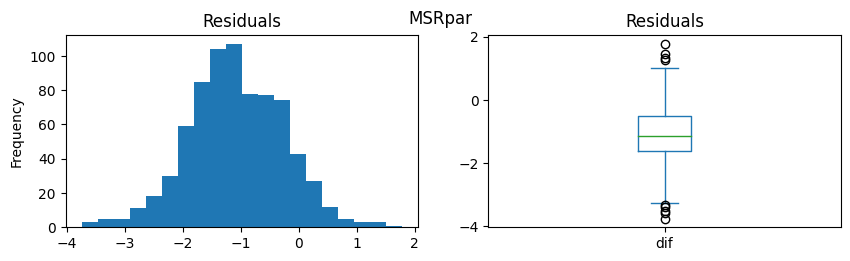

In [109]:
df_msrpar = ind_report('MSRpar')
df_msrpar.head()

#### 4.1.2. SMTeuroparl

The training data includes all of the Europarl human ranked fr-en system submissions from WMT 2007,
with each machine translation being paired with the correct reference translation. This resulted in 729
unique training pairs. The test data is comprised of all Europarl human evaluated fr-en pairs from WMT
2008 that contain 16 white space delimited tokens or less.

As a summary, it's the result of the same translations done by different people.

**Statistic Results**
- There can be found 2 groups in differences analysis:
    - A group of translations whose similarity has been well estimated (aroun 0.5 error). These are probably translations using similar words due to the nature of the sentence (more concrete ones)
    - Another one with higher errors (around 3). These are probably translations using different words, determinants or tenses.
- This one's performance could be improved with good semantic analysis for words (e.g. using word embeddings)

SMTEuroparl


RAW TEXT (DIFFERENCE -4.55)
That provision could open the door wide to arbitrariness. 
 This regulation point opens the door to the arbitrary one.

PREPROCESSED TEXT
{'wide', 'door', 'could', 'open', 'arbitrariness', 'provision'} 
 {'one', 'arbitrary', 'door', 'opens', 'regulation', 'point'}
INTERSECTION {'door'}
DIFFERENCE {'one', 'wide', 'arbitrary', 'opens', 'could', 'regulation', 'point', 'arbitrariness', 'open', 'provision'}



RAW TEXT (DIFFERENCE -4.55)
That provision could open the door wide to arbitrariness. 
 This point of the regulations opens the door to arbitrary power.

PREPROCESSED TEXT
{'wide', 'door', 'could', 'open', 'arbitrariness', 'provision'} 
 {'arbitrary', 'door', 'opens', 'point', 'power', 'regulations'}
INTERSECTION {'door'}
DIFFERENCE {'wide', 'arbitrary', 'opens', 'could', 'point', 'arbitrariness', 'open', 'power', 'regulations', 'provision'}



RAW TEXT (DIFFERENCE -4.55)
That provision could open the door wide to arbitrariness. 
 This point o

,0,1,gs,sim,dif
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,4.50,1.428571,-3.071429
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,5.00,3.750000,-1.250000
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,4.25,1.363636,-2.886364
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,4.50,2.142857,-2.357143
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...",5.00,5.000000,0.000000


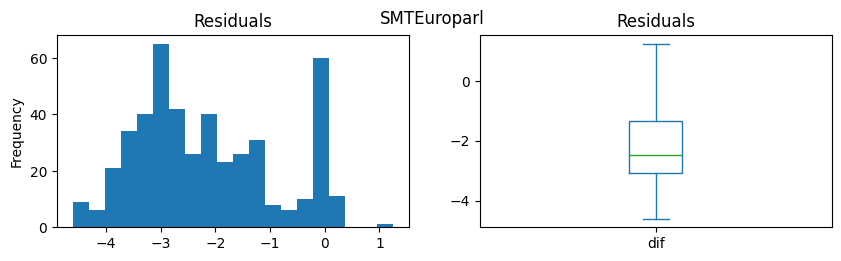

In [111]:
df_euro = ind_report('SMTEuroparl')
df_euro.head()

#### 4.1.3. SMTNews

Dataset comprising of all the human ranked fr-en system submissions from the WMT 2007 news conversation test set.

**Statistic Results**
- Similar to the ones obtained for the SMTeuroparl dataset.
- It makes sense given the Machine Translation origin of both.

surprise.SMTnews


RAW TEXT (DIFFERENCE -4.60)
Other ways are needed. 
 Other means should be found.

PREPROCESSED TEXT
{'needed', 'ways'} 
 {'found', 'means'}
INTERSECTION set()
DIFFERENCE {'found', 'means', 'ways', 'needed'}



RAW TEXT (DIFFERENCE -4.60)
Other ways are needed. 
 Other means should be found.

PREPROCESSED TEXT
{'needed', 'ways'} 
 {'found', 'means'}
INTERSECTION set()
DIFFERENCE {'found', 'means', 'ways', 'needed'}



RAW TEXT (DIFFERENCE -4.62)
Western Europeans, who have been spared this legacy, should heed our warnings. 
 Europeans of the West, who forgot this history, should take account of our warning statements.

PREPROCESSED TEXT
{'warnings', 'heed', 'europeans', 'western', 'legacy', 'spared'} 
 {'history', 'warning', 'statements', 'europeans', 'forgot', 'account', 'west', 'take'}
INTERSECTION {'europeans'}
DIFFERENCE {'warnings', 'history', 'warning', 'heed', 'statements', 'take', 'western', 'forgot', 'legacy', 'account', 'west', 'spared'}



RAW TEXT (DIFFER

,0,1,gs,sim,dif
0,The leaders have now been given a new chance a...,The leaders benefit aujourd' hui of a new luck...,4.50,1.428571,-3.071429
1,Amendment No 7 proposes certain changes in the...,Amendment No 7 is proposing certain changes in...,5.00,3.750000,-1.250000
2,Let me remind you that our allies include ferv...,I would like to remind you that among our alli...,4.25,1.363636,-2.886364
3,The vote will take place today at 5.30 p.m.,The vote will take place at 5.30pm,4.50,2.142857,-2.357143
4,"The fishermen are inactive, tired and disappoi...","The fishermen are inactive, tired and disappoi...",5.00,5.000000,0.000000


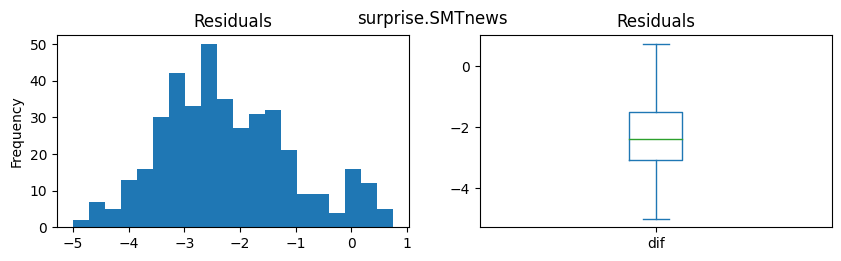

In [113]:
df_news = ind_report('surprise.SMTnews')
df_news.head()

### 4.2. Best Performing Datasets

#### 4.2.1. MSRvid

Contains video descriptions made by different annotators.

**Statistic Results**

- Most of the differences are around 0 so similarity is well estimated.
- There's a constant distributions of negative differences (from -2.5 to 0). The main reason is probably the use of different words to describe the same thing.
- There are also positive differences (from 0 to 1.5). The main reason is probably similar words describing different actions. For example "The kid is playing football" and "The kid is playing the piano".
- The differences could be solved in a similar way than for Machine Translation, capturing semantic information.

MSRvid


RAW TEXT (DIFFERENCE -4.00)
A man is playing the drums. 
 A man plays the drum.

PREPROCESSED TEXT
{'man', 'drums', 'playing'} 
 {'man', 'drum', 'plays'}
INTERSECTION {'man'}
DIFFERENCE {'drum', 'drums', 'playing', 'plays'}



RAW TEXT (DIFFERENCE -4.00)
A band is performing on a stage. 
 A band is playing onstage.

PREPROCESSED TEXT
{'band', 'stage', 'performing'} 
 {'band', 'onstage', 'playing'}
INTERSECTION {'band'}
DIFFERENCE {'onstage', 'stage', 'performing', 'playing'}



RAW TEXT (DIFFERENCE -4.00)
The lady sliced a tomatoe. 
 Someone is cutting a tomato.

PREPROCESSED TEXT
{'tomatoe', 'lady', 'sliced'} 
 {'cutting', 'tomato', 'someone'}
INTERSECTION set()
DIFFERENCE {'lady', 'sliced', 'tomato', 'someone', 'cutting', 'tomatoe'}



RAW TEXT (DIFFERENCE -4.00)
A person plays a keyboard. 
 Someone is playing a keyboard.

PREPROCESSED TEXT
{'keyboard', 'person', 'plays'} 
 {'keyboard', 'playing', 'someone'}
INTERSECTION {'keyboard'}
DIFFERENCE {'person', 'playing', 'someone

,0,1,gs,sim,dif
0,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.,5.00,4.000000,-1.000000
1,A plane is taking off.,An air plane is taking off.,5.00,3.333333,-1.666667
2,A young child is riding a horse.,A child is riding a horse.,4.75,3.750000,-1.000000
3,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.,5.00,5.000000,0.000000
4,A man is playing a large flute.,A man is playing a flute.,3.80,3.750000,-0.050000


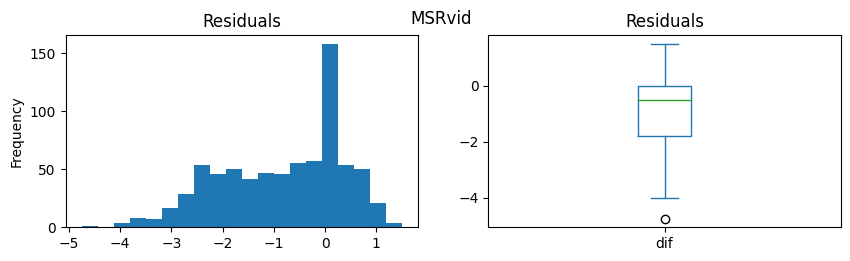

In [114]:
df_msrvid = ind_report('MSRvid')
df_msrvid.head()

#### 4.2.2 OnWN Dataset

The last dataset is radically different as it comprised 750 pairs of glosses from OntoNotes 4.0 (Hovy et al., 2006) and WordNet 3.1 (Fellbaum, 1998) senses. The mapping of the senses of both resources comprised 110K sense pairs.

**Statistic Results**
- In this case the performance is quite worse than for `MSRvid`. Error distributions are distributed around -2.
- The reason in this case is the use of different word to describe the same thing (e.g. "Bring back to life, return from the dead" and "cause to become alive again")
- Stemming/lemmatization and better semantic analysis could be used to improve the results.

surprise.OnWN


RAW TEXT (DIFFERENCE -4.75)
restrict or confine 
 place limits on (extent or access).

PREPROCESSED TEXT
{'restrict', 'confine'} 
 {'access', 'limits', 'extent', 'place'}
INTERSECTION set()
DIFFERENCE {'restrict', 'limits', 'confine', 'extent', 'access', 'place'}



RAW TEXT (DIFFERENCE -4.75)
indicate, be signs or symptoms of 
 be a signal for or a symptom of.

PREPROCESSED TEXT
{'signs', 'indicate', 'symptoms'} 
 {'symptom', 'signal'}
INTERSECTION set()
DIFFERENCE {'signs', 'indicate', 'symptoms', 'signal', 'symptom'}



RAW TEXT (DIFFERENCE -4.75)
physically inflate 
 become inflated.

PREPROCESSED TEXT
{'physically', 'inflate'} 
 {'inflated', 'become'}
INTERSECTION set()
DIFFERENCE {'inflated', 'become', 'physically', 'inflate'}



RAW TEXT (DIFFERENCE -4.75)
Bring back to life, return from the dead 
 cause to become alive again.

PREPROCESSED TEXT
{'dead', 'return', 'back', 'bring', 'life'} 
 {'become', 'alive', 'cause'}
INTERSECTION set()
DIFFERENCE {'become', 'de

,0,1,gs,sim,dif
0,render one language in another language,restate (words) from one language into another...,5.00,2.500000,-2.500000
1,"nations unified by shared interests, history o...",a group of nations having common interests.,3.25,1.250000,-2.000000
2,"convert into absorbable substances, (as if) wi...",soften or disintegrate by means of chemical ac...,3.25,0.909091,-2.340909
3,"devote or adapt exclusively to an skill, study...",devote oneself to a special area of work.,4.00,1.111111,-2.888889
4,elevated wooden porch of a house,a porch that resembles the deck on a ship.,3.25,0.714286,-2.535714


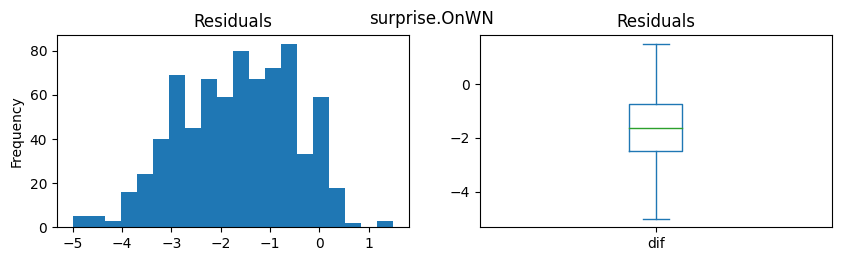

In [115]:
df_onwn = ind_report('surprise.OnWN')
df_onwn.head()

## 5. Conclusions

- There are mainly 3 kinds of datasets:
    - Machine Translations
    - Paraphrasing
    - Descriptions
- In general, this baseline method works well for descriptions (around 70% correlation wimth gold standard) it doesn't for paraphrasing (around 55%) and machine translations (around 40%).
- The main reason, is that the current method is not able to capture the semantic meaning of the sentences but only the word overlap.

**Future Work**
- Improve text preprocessing. Most of the problems are caused by easily fixable things such as text standardization (e.g. lemmatization, stemming, etc)
- Use semantic analysis to capture the meaning of the sentences. For example with pretrained word embeddings, entity detections, etc.